In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import netCDF4 as nc
import datetime as dt
import cmocean
import sys
sys.path.append('/ocean/eolson/MEOPAR/analysis-elise/notebooks/databases/')
#import dataProcess as dpro
#sys.path.append('/ocean/eolson/MEOPAR/analysis-elise/notebooks/PARModel/doc/')
#import commonFuns as cf
from salishsea_tools import loadDataFRP as cf, evaltools as et
import matplotlib
from salishsea_tools.geo_tools import find_closest_model_point
from salishsea_tools.viz_tools import set_aspect
import f90nml

%matplotlib inline

matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'legend.numpoints': 1})

In [2]:
fm=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc')
tmask=np.copy(fm.variables['tmask'])
navlon=np.copy(fm.variables['nav_lon'])
navlat=np.copy(fm.variables['nav_lat'])
e3t=np.copy(fm.variables['e3t_0'])
fm.close()

In [3]:
np.shape(navlon),np.shape(tmask[0,0,:,:])

((898, 398), (898, 398))

In [28]:
prefix='TRACE2SC_3'
fileLoc='CedarRuns'

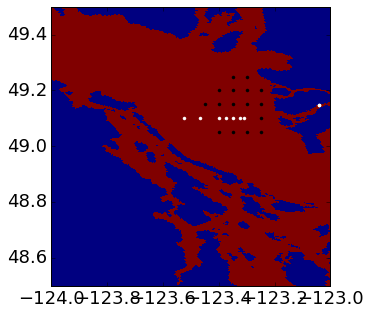

In [29]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.pcolormesh(navlon,navlat,tmask[0,0,:,:])
ax.set_xlim((-124,-123))
ax.set_ylim((48.5,49.5))
ax.plot([-123.04000000000001, -123.04000000000001, -123.5266, -123.46701670000002, -123.40041670000001, -123.3755, -123.34999999999999, -123.32466670000001, -123.309],
        [49.14833333, 49.14833333, 49.099983330000001, 49.10038333, 49.100583329999999, 49.100499999999997, 49.100000000000001, 49.100333329999998, 49.101500000000001],
        'w.')
ax.plot([-123.45, -123.4, -123.35, -123.3, -123.25,-123.25, -123.4, -123.35, -123.3, -123.25, -123.35, -123.3, -123.4, -123.35, -123.3, -123.25],
        [49.15, 49.15, 49.15, 49.15, 49.15,49.1,49.2, 49.2, 49.2, 49.2,49.25, 49.25, 49.05, 49.05, 49.05, 49.05],
        'k.')

In [30]:
def plotTS(df0,f,stas0,fig2,ax2,fs,vthresh):
    # get model indices for time and location:
    dtfUTC=np.array([et.datetimeToDecDay(dt.datetime(1900,1,1)+dt.timedelta(seconds=ii)) 
                     for ii in f.variables['time_counter'][:]])
    date=str(df0.loc[df0['Station']==stas0[0]]['Date_UTC'].values[0])
    iyr=int(date[0:4])
    imon=int(date[4:6])
    iday=int(date[6:])
    itime=df0.loc[df0['Station']==stas0[0]]['Time_UTC_DecDay'].values[0]
    dtObsUTC=et.datetimeToDecDay(dt.datetime(iyr,imon,iday)+dt.timedelta(days=itime))
    tt=np.argmin(np.abs(dtfUTC-dtObsUTC))
    print('tt=',tt)
    lat=list()
    lon=list()
    for ista in stas0:
        lati=df0.loc[df0['Station']==ista]['LatDecDeg'].values[0]
        loni=df0.loc[df0['Station']==ista]['LonDecDeg'].values[0]
        lat.append(lati)
        lon.append(loni)
    for ilat, ilon in zip((49.15, 49.15, 49.15, 49.15, 49.15,49.1,49.2, 49.2, 49.2, 49.2,49.25, 49.25, 49.05, 49.05, 49.05, 49.05),
                         (-123.04000000000001, -123.04000000000001, -123.5266, -123.46701670000002, -123.40041670000001, -123.3755, -123.34999999999999, -123.32466670000001, -123.309)):
        lat.append(ilat)
        lon.append(ilon)
    stas=stas0
    
    print(lat)
    print(lon)
    
    for ilat, ilon in zip(lat,lon):
        jj,ii=find_closest_model_point(ilon,ilat,f.variables['nav_lon'][:,:],f.variables['nav_lat'][:,:])
        iters=(('TUR1','blueviolet'),
               ('TUR2','blue'),
               ('TUR3','aquamarine'),
               ('TUR4','skyblue'),
               ('TUR5','lime'),
               ('TUR6','green'),
               ('TUR7','darkkhaki'),
               ('TUR8','darkgoldenrod'),
               ('TUR9','darkorange'),
               ('TUR10','crimson'))
        p=dict()
        count=0
        for (tvar,col) in iters:
            count+=1
            tplot=np.ma.masked_where(tmask[0,:,jj,ii]==0,f.variables[tvar][tt,:,jj,ii])
            splot=np.ma.masked_where(np.logical_or(tmask[0,:,jj,ii]==0,f.variables['deptht'][:]>=vthresh),
                                     fs.variables['vosaline'][tt,:,jj,ii])
            p[count],=ax2.plot(splot,tplot,'o',color=col,mew=0,alpha=.5,
                          label=[x+' {},'.format(nml['nampisriv'][x][count-1]) for x in nml['nampisriv'].keys()])
    for ista in stas0:
        izC=zCasts[ista].dCast
        p[count+1],=ax2.plot(izC['gsw_srA0'].loc[izC['prSM']<vthresh],izC['turb'].loc[izC['prSM']<vthresh],'kx',
                 markersize=10,mew=2,alpha=.5)
        izC=zCasts[ista].uCast
        ax2.plot(izC['gsw_srA0'].loc[izC['prSM']<vthresh],izC['turb'].loc[izC['prSM']<vthresh],'k+',
                 markersize=10,mew=2,alpha=.25)
    
    ax2.legend(handles=[p[1],p[2],p[3],p[4],p[5],p[6],p[7],p[8],p[9],p[10],p[11]], #,p[12],p[13]
              loc=6, bbox_to_anchor=(1.05,.5),borderaxespad=0.,fontsize=20)
    ax2.set_title(dt.datetime(iyr,imon,iday))
    ax2.set_xlabel('Salinity')
    ax2.set_ylabel('Turbidity (NTU)')
    ax2.set_title('Upper '+str(vthresh)+'m')

In [31]:
def RMSE_TS(df0,f,stas,fs,vthresh):
    # get model indices for time and location:
    dtfUTC=np.array([et.datetimeToDecDay(dt.datetime(1900,1,1)+dt.timedelta(seconds=ii)) 
                     for ii in f.variables['time_counter'][:]])
    date=str(df0.loc[df0['Station']==stas[0]]['Date_UTC'].values[0])
    iyr=int(date[0:4])
    imon=int(date[4:6])
    iday=int(date[6:])
    itime=df0.loc[df0['Station']==stas[0]]['Time_UTC_DecDay'].values[0]
    dtObsUTC=et.datetimeToDecDay(dt.datetime(iyr,imon,iday)+dt.timedelta(days=itime))
    tt=np.argmin(np.abs(dtfUTC-dtObsUTC))
    print('tt=',tt)
    lat=list()
    lon=list()
    for ista in stas:
        lati=df0.loc[df0['Station']==ista]['LatDecDeg'].values[0]
        loni=df0.loc[df0['Station']==ista]['LonDecDeg'].values[0]
        lat.append(lati)
        lon.append(loni)
    for ilat, ilon in zip((49.15, 49.15, 49.15, 49.15, 49.15,49.1,49.2, 49.2, 49.2, 49.2,49.25, 49.25, 49.05, 49.05, 49.05, 49.05),
                         (-123.04000000000001, -123.04000000000001, -123.5266, -123.46701670000002, -123.40041670000001, -123.3755, -123.34999999999999, -123.32466670000001, -123.309)):
        lat.append(ilat)
        lon.append(ilon)
    
    varnames=('TUR1','TUR2','TUR3','TUR4','TUR5','TUR6','TUR7','TUR8','TUR9','TUR10')
    allt=dict()
    alls=dict()
    for tvar in varnames:
        allt[tvar]=list()
        alls[tvar]=list()
        allt['obs']=list()
        alls['obs']=list()
    for ilat, ilon in zip(lat,lon):
        jj,ii=find_closest_model_point(ilon,ilat,f.variables['nav_lon'][:,:],f.variables['nav_lat'][:,:])
        for tvar in varnames:
            tplot=np.ma.masked_where(np.logical_or(tmask[0,:,jj,ii]==0,f.variables['deptht'][:]>=vthresh),
                                     np.mean(f.variables[tvar][(tt-6):(tt+18),:,jj,ii],0))
            splot=np.ma.masked_where(np.logical_or(tmask[0,:,jj,ii]==0,f.variables['deptht'][:]>=vthresh),
                                     np.mean(fs.variables['vosaline'][(tt-6):(tt+18),:,jj,ii],0))
            for i in tplot[~tplot.mask]:
                allt[tvar].append(i)
            for i in splot[~splot.mask]:
                alls[tvar].append(i)
    for ista in stas:
        izC=zCasts[ista].dCast
        for i in izC['gsw_srA0'].loc[izC['prSM']<vthresh].values:
            alls['obs'].append(i)
        for i in  izC['turb'].loc[izC['prSM']<vthresh].values:
            allt['obs'].append(i)
        izC=zCasts[ista].uCast
        for i in izC['gsw_srA0'].loc[izC['prSM']<vthresh].values:
            alls['obs'].append(i)
        for i in  izC['turb'].loc[izC['prSM']<vthresh].values:
            allt['obs'].append(i)
    return allt, alls

In [32]:
df0, zCasts=cf.loadDataFRP(exp='all',sel='wide')
df0.loc[df0.Station==14.2,'LonDecDeg']=float(df0.loc[df0.Station==14.2,'LonDecDeg_bottom'])
df0.loc[df0.Station==14.2,'LatDecDeg']=float(df0.loc[df0.Station==14.2,'LatDecDeg_bottom'])

### April

In [33]:
rundir1='/data/eolson/MEOPAR/SS36runs/'+fileLoc+'/'+prefix+'_06apr17'
f1=nc.Dataset(os.path.join(rundir1,'SalishSea_1h_20170406_20170415_ptrc_T.nc'))
f1s=nc.Dataset(os.path.join(rundir1,'SalishSea_1h_20170406_20170415_grid_T.nc'))
nml=f90nml.read(os.path.join(rundir1,'namelist_trace2_cfg'))
stas=df0.loc[df0['Date']==20170410]['Station'].values

april 10 buoy turbidity range: 17.21--26.57

tt= 113
[49.14833333, 49.14833333, 49.099983330000001, 49.10038333, 49.100583329999999, 49.100499999999997, 49.100000000000001, 49.100333329999998, 49.101500000000001, 49.15, 49.15, 49.15, 49.15, 49.15, 49.1, 49.2, 49.2, 49.2]
[-123.04000000000001, -123.04000000000001, -123.5266, -123.46701670000002, -123.40041670000001, -123.3755, -123.34999999999999, -123.32466670000001, -123.309, -123.04, -123.04, -123.5266, -123.46701670000002, -123.40041670000001, -123.3755, -123.35, -123.32466670000001, -123.309]


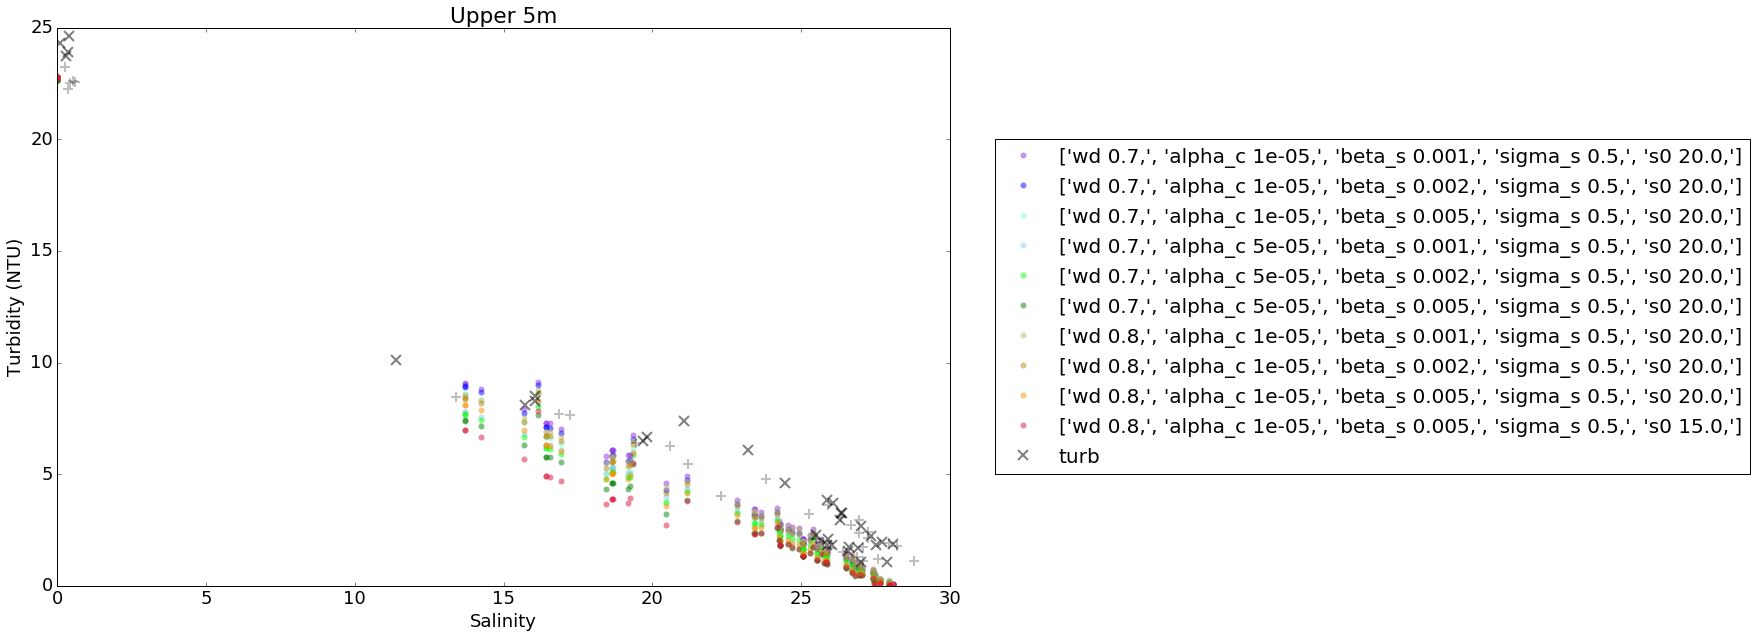

In [34]:
fig2,ax2=plt.subplots(1,1,figsize=(16,10))
plotTS(df0,f1,stas,fig2,ax2,f1s,5)

In [35]:
allt_april,alls_april=RMSE_TS(df0,f1,stas,f1s,5)

tt= 113


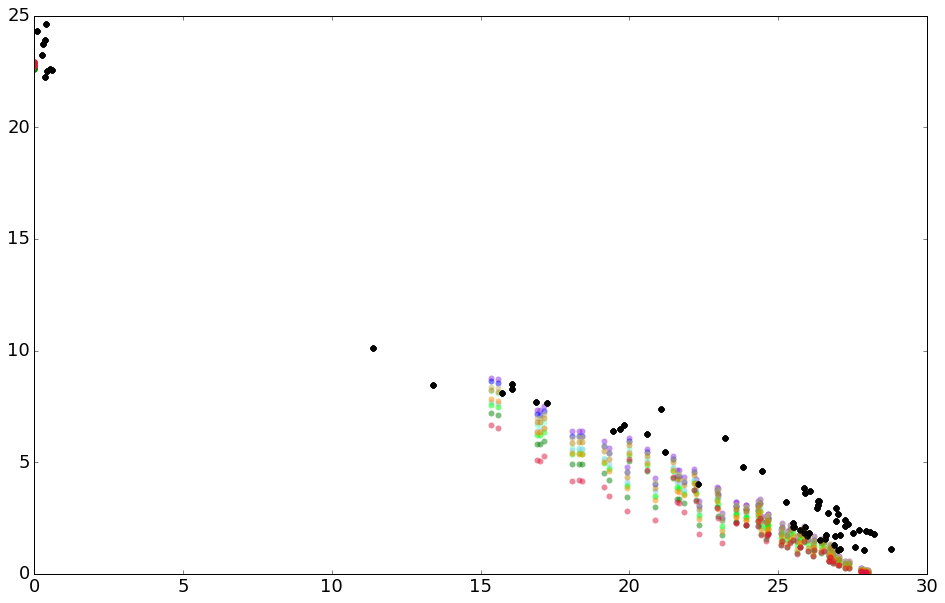

In [36]:
fig,ax=plt.subplots(1,1,figsize=(16,10))
iters=(('TUR1','blueviolet'),
       ('TUR2','blue'),
       ('TUR3','aquamarine'),
       ('TUR4','skyblue'),
       ('TUR5','lime'),
       ('TUR6','green'),
       ('TUR7','darkkhaki'),
       ('TUR8','darkgoldenrod'),
       ('TUR9','darkorange'),
       ('TUR10','crimson'))
for tval, col in iters:
    ax.plot(alls_april[tval],allt_april[tval],'o',color=col,mew=0,alpha=.5)
    ax.plot(alls_april['obs'],allt_april['obs'],'ko',mew=0,alpha=.5)

### May

In [37]:
rundir2='/data/eolson/MEOPAR/SS36runs/'+fileLoc+'/'+prefix+'_26may17'
f2=nc.Dataset(os.path.join(rundir2,'SalishSea_1h_20170526_20170604_ptrc_T.nc'))
f2s=nc.Dataset(os.path.join(rundir2,'SalishSea_1h_20170526_20170604_grid_T.nc'))
nml=f90nml.read(os.path.join(rundir2,'namelist_trace2_cfg'))
stas2=df0.loc[df0['Date']==20170531]['Station'].values

tt= 137
[49.039499999999997, 49.100809999999996, 49.101079999999996, 49.100369999999998, 49.100850000000001, 49.102620000000002, 49.110550000000003, 49.120699999999999, 49.101680000000002, 49.148290000000003, 49.15, 49.15, 49.15, 49.15, 49.15, 49.1, 49.2, 49.2, 49.2]
[-123.25964999999999, -123.53372, -123.46722, -123.40012, -123.37567, -123.37766999999999, -123.34851999999999, -123.3185, -123.30883, -123.03928000000001, -123.04, -123.04, -123.5266, -123.46701670000002, -123.40041670000001, -123.3755, -123.35, -123.32466670000001, -123.309]


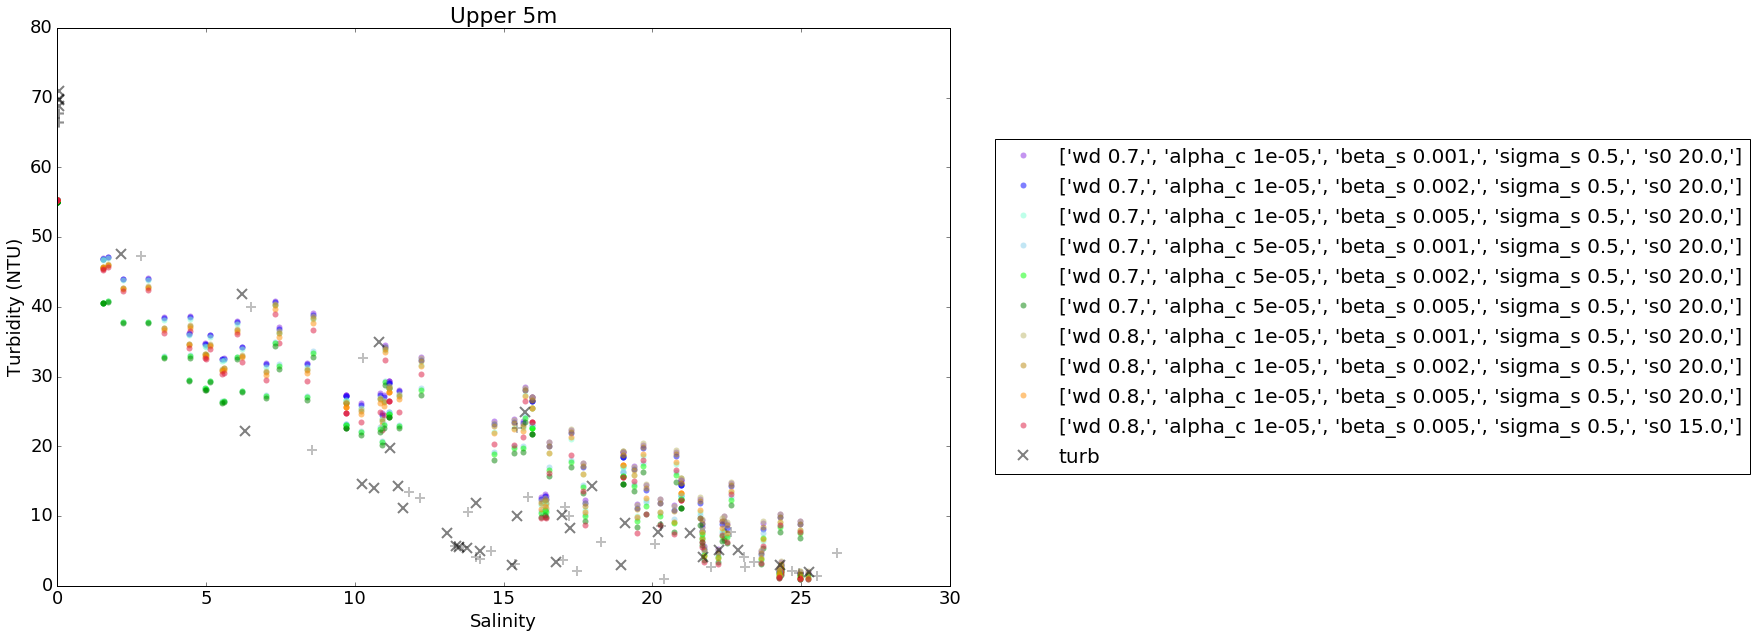

In [38]:
fig2,ax2=plt.subplots(1,1,figsize=(16,10))
plotTS(df0,f2,stas2,fig2,ax2,f2s,5)

In [39]:
allt_may,alls_may=RMSE_TS(df0,f2,stas2,f2s,5)

tt= 137


### November

In [37]:
rundir3='/data/eolson/MEOPAR/SS36runs/'+fileLoc+'/'+prefix+'_26may17'
f2=nc.Dataset(os.path.join(rundir2,'SalishSea_1h_20170526_20170604_ptrc_T.nc'))
f2s=nc.Dataset(os.path.join(rundir2,'SalishSea_1h_20170526_20170604_grid_T.nc'))
nml=f90nml.read(os.path.join(rundir2,'namelist_trace2_cfg'))
stas2=df0.loc[df0['Date']==20170531]['Station'].values

tt= 137
[49.039499999999997, 49.100809999999996, 49.101079999999996, 49.100369999999998, 49.100850000000001, 49.102620000000002, 49.110550000000003, 49.120699999999999, 49.101680000000002, 49.148290000000003, 49.15, 49.15, 49.15, 49.15, 49.15, 49.1, 49.2, 49.2, 49.2]
[-123.25964999999999, -123.53372, -123.46722, -123.40012, -123.37567, -123.37766999999999, -123.34851999999999, -123.3185, -123.30883, -123.03928000000001, -123.04, -123.04, -123.5266, -123.46701670000002, -123.40041670000001, -123.3755, -123.35, -123.32466670000001, -123.309]


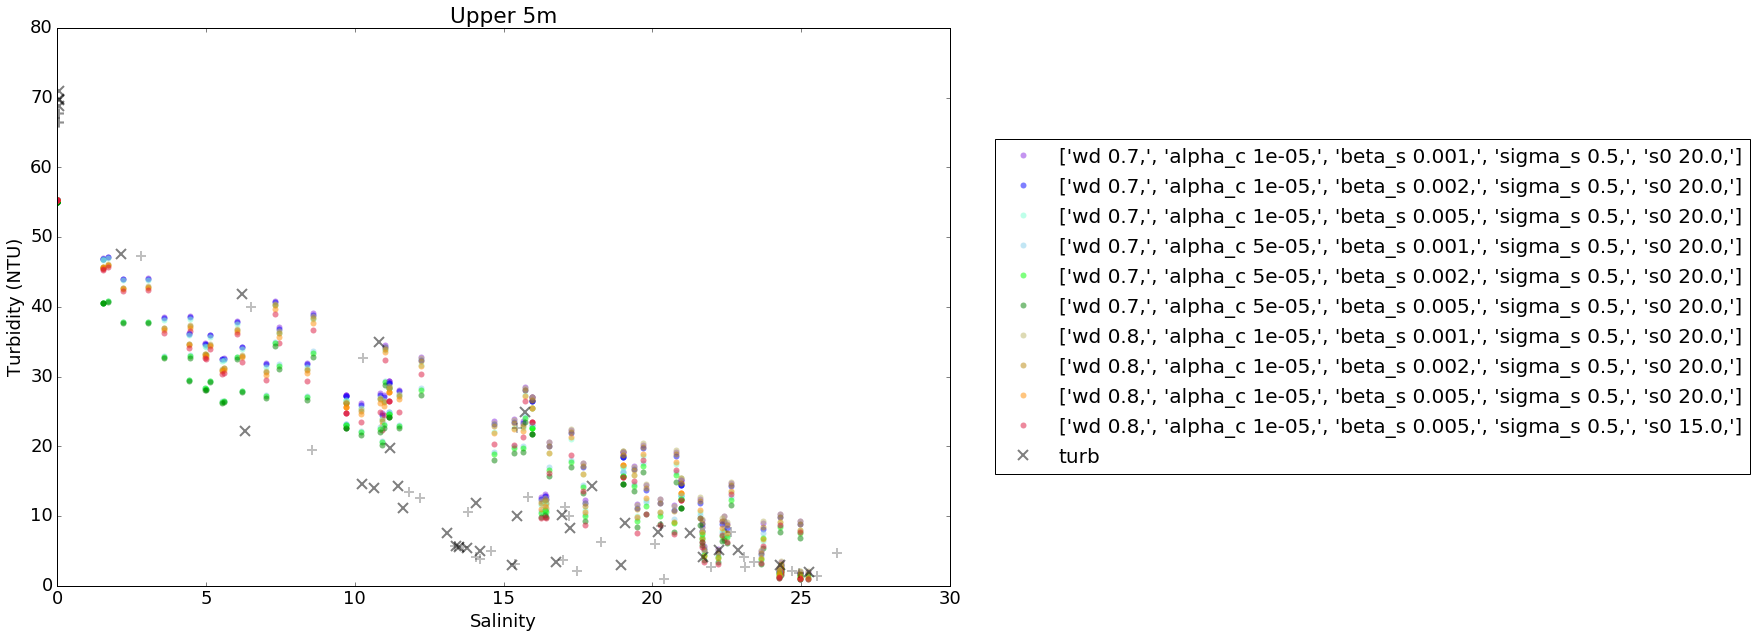

In [38]:
fig2,ax2=plt.subplots(1,1,figsize=(16,10))
plotTS(df0,f2,stas2,fig2,ax2,f2s,5)
plotTS(df0,f1,stas,fig2,ax2,f1s,5)

In [39]:
allt_may,alls_may=RMSE_TS(df0,f2,stas2,f2s,5)

tt= 137


In [40]:
def binTS(alltmon,allsmon):
    # basic: bin average, then compare:
    sbin=np.arange(0,30,4)
    tbar=dict()
    for ik in alltmon.keys():
        indt=np.digitize(allsmon[ik],sbin)
        tbar[ik]=np.empty((len(sbin)-1,1))
        tbar[ik][:]=np.nan
        for ii in range(1,len(sbin)):
            ij=indt==ii
            allt=np.array(alltmon[ik])
            if np.sum(ij)>0:
                tbar[ik][ii-1]=np.nanmean(allt[ij])
    keylist=set([ik for ik in alltmon.keys()])-{'obs'}
    spos=.5*(sbin[:-1]+sbin[1:])
    fig,ax=plt.subplots(1,1,figsize=(6,4))
    for ik in keylist:
        ax.plot(spos,tbar[ik]-tbar['obs'],label=ik)
    plt.legend(bbox_to_anchor=(1.5,1))
    return sbin,keylist,tbar

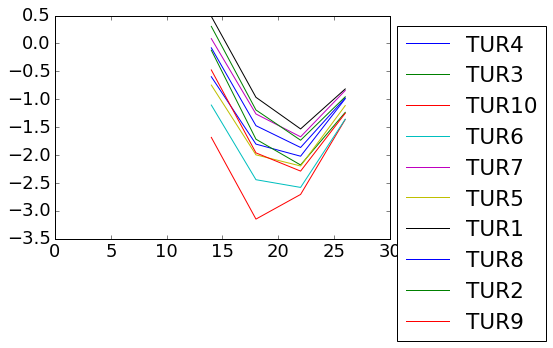

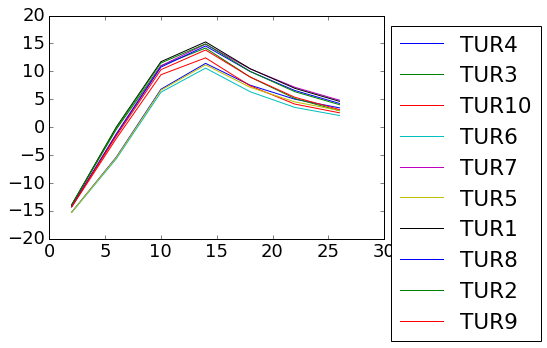

In [41]:
sbin,keylist,tbar_april=binTS(allt_april,alls_april)
sbin,keylist,tbar_may=binTS(allt_may,alls_may)

In [42]:
RMSE_april=dict()
RMSE_may=dict()
RMSE_combined=dict()
RMSE_avg=dict()
for ik in keylist:
    RMSE_april[ik]=np.sqrt(np.nansum((tbar_april[ik]-tbar_april['obs'])**2))
    RMSE_may[ik]=np.sqrt(np.nansum((tbar_may[ik]-tbar_may['obs'])**2))
    RMSE_combined[ik]=np.sqrt(np.nansum((tbar_april[ik]-tbar_april['obs'])**2)+np.nansum((tbar_may[ik]-tbar_may['obs'])**2))
    RMSE_avg[ik]=.5*(RMSE_april[ik]+RMSE_may[ik])
for ik in keylist:
    print(ik,RMSE_april[ik],RMSE_may[ik],RMSE_combined[ik],RMSE_avg[ik])

TUR4 3.00393048959 23.0576323908 23.2524839502 13.0307814402
TUR3 3.07147279778 25.1562628454 25.3430760859 14.1138678216
TUR10 4.70710652755 23.0204246982 23.496740309 13.8637656129
TUR6 4.00413171477 21.7711807285 22.1363362168 12.8876562217
TUR7 2.31146168611 26.9948559808 27.0936358681 14.6531588335
TUR5 3.30989677355 22.6196147415 22.8604984133 12.9647557575
TUR1 2.09305384793 27.2765422462 27.356729178 14.684798047
TUR8 2.61524724993 26.3069729967 26.436647791 14.4611101233
TUR2 2.37493741305 26.5553602854 26.6613481955 14.4651488492
TUR9 3.33167484589 24.9475285432 25.169013443 14.1396016945


In [43]:
#TUR6 best overall:
print('wd',nml['nampisriv']['wd'][5],'alpha_c',nml['nampisriv']['alpha_c'][5],nml['nampisriv']['beta_s'][5])
#TUR5 next best:
print('wd',nml['nampisriv']['wd'][4],'alpha_c',nml['nampisriv']['alpha_c'][4],nml['nampisriv']['beta_s'][4])
#TUR4 next best:
print('wd',nml['nampisriv']['wd'][3],'alpha_c',nml['nampisriv']['alpha_c'][3],nml['nampisriv']['beta_s'][3])

wd 0.7 alpha_c 5e-05 0.005
wd 0.7 alpha_c 5e-05 0.002
wd 0.7 alpha_c 5e-05 0.001


In [44]:
# based on April, TUR1 is best:
print('wd',nml['nampisriv']['wd'][0],'alpha_c',nml['nampisriv']['alpha_c'][0],nml['nampisriv']['beta_s'][0])
# then TUR7:
print('wd',nml['nampisriv']['wd'][6],'alpha_c',nml['nampisriv']['alpha_c'][6],nml['nampisriv']['beta_s'][6])
# then TUR2:
print('wd',nml['nampisriv']['wd'][1],'alpha_c',nml['nampisriv']['alpha_c'][1],nml['nampisriv']['beta_s'][1])

wd 0.7 alpha_c 1e-05 0.001
wd 0.8 alpha_c 1e-05 0.001
wd 0.7 alpha_c 1e-05 0.002


In [45]:
# based on May, TUR6 is best:
print('wd',nml['nampisriv']['wd'][5],'alpha_c',nml['nampisriv']['alpha_c'][5],nml['nampisriv']['beta_s'][5])
# then TUR5:
print('wd',nml['nampisriv']['wd'][4],'alpha_c',nml['nampisriv']['alpha_c'][4],nml['nampisriv']['beta_s'][4])
# then TUR10:
print('wd',nml['nampisriv']['wd'][9],'alpha_c',nml['nampisriv']['alpha_c'][9],nml['nampisriv']['beta_s'][9])

wd 0.7 alpha_c 5e-05 0.005
wd 0.7 alpha_c 5e-05 0.002
wd 0.8 alpha_c 1e-05 0.005


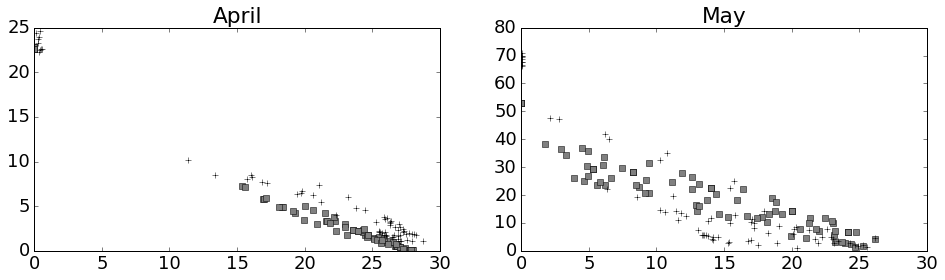

In [46]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
ax[0].plot(alls_april['TUR6'],allt_april['TUR6'],'s',color='gray')
ax[0].plot(alls_april['obs'],allt_april['obs'],'+',color='k')
ax[0].set_title('April')
ax[1].plot(alls_may['TUR6'],allt_may['TUR6'],'s',color='gray')
ax[1].plot(alls_may['obs'],allt_may['obs'],'+',color='k')
ax[1].set_title('May')

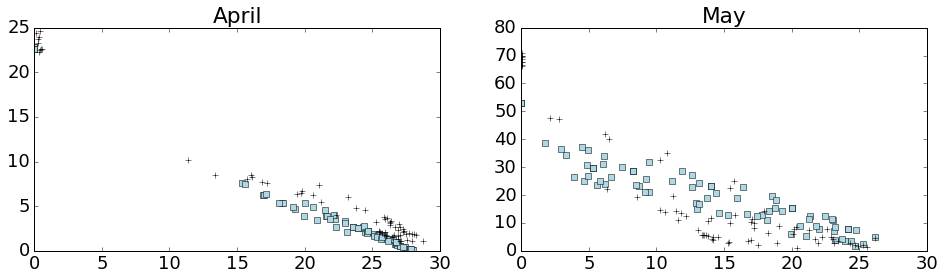

In [47]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
ax[0].plot(alls_april['TUR5'],allt_april['TUR5'],'s',color='lightblue')
ax[0].plot(alls_april['obs'],allt_april['obs'],'+',color='k')
ax[0].set_title('April')
ax[1].plot(alls_may['TUR5'],allt_may['TUR5'],'s',color='lightblue')
ax[1].plot(alls_may['obs'],allt_may['obs'],'+',color='k')
ax[1].set_title('May')

In [48]:
alls_april.keys()

dict_keys(['TUR8', 'TUR4', 'TUR1', 'TUR10', 'TUR2', 'TUR7', 'TUR9', 'TUR3', 'obs', 'TUR6', 'TUR5'])